### Importing Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from IPython import display

from dolfin import *
from rbnics import *
try:
    from ufl_legacy import transpose
except ImportError:
    from ufl import transpose



### Cylinder Data Loading

In [13]:
# Load the .mat files
all_data = scipy.io.loadmat('data/CYLINDER_ALL.mat')

# Access variable names of data file
data_variable_names = list(all_data.keys())
print(data_variable_names)

# Extract the data
UALL = all_data['UALL']
VALL = all_data['VALL']
VORTALL = all_data['VORTALL']

print("Shape of UALL = ", UALL.shape, "Size of UALL = ", UALL.size)
print("Shape of VALL = ", VALL.shape, "Size of x_velocity = ", VALL.size)
print("Shape of VORTALL = ", VORTALL.shape, "Size of x_velocity = ", VORTALL.size)

m = all_data['m'].item()  # Number of evenly spaced samples in X-Direction
n = all_data['n'].item()  # Number of evenly spaced samples in Y-Direction
nx = all_data['nx'].item()  # End point for the grid-generation in X-Direction
ny = all_data['ny'].item()  # End point for the grid-generation in X-Direction

print("m_val = ", m, "n_val = ", n)
print("nx_val = ", nx, "ny_val = ", ny)

num_snapshots_data = UALL.shape[1]
print("Number of snapshots = ", num_snapshots_data)

['__header__', '__version__', '__globals__', 'UALL', 'UEXTRA', 'VALL', 'VEXTRA', 'VORTALL', 'VORTEXTRA', 'm', 'n', 'nx', 'ny']
['__header__', '__version__', '__globals__', 'vortAVG', 'vortPHI', 'vortUNSTEADY']
Shape of UALL =  (89351, 151) Size of UALL =  13492001
Shape of VALL =  (89351, 151) Size of x_velocity =  13492001
Shape of VORTALL =  (89351, 151) Size of x_velocity =  13492001
m_val =  199 n_val =  449
nx_val =  199 ny_val =  449
Number of snapshots =  151


### Cylinder Basis Data Loading 

In [14]:
# Loading the basis data
basis_data = scipy.io.loadmat('CYLINDER_basis.mat')

# Loading Basis File
basis_variable_names = list(basis_data.keys())
print(basis_variable_names)

vortAVG = basis_data['vortAVG']
vortPHI = basis_data['vortPHI']
vortUNSTEADY = basis_data['vortUNSTEADY']

print("Shape of vortAVG = ", vortAVG.shape, "Size of vortAVG = ", vortAVG.size)
print("Shape of vortPHI = ", vortPHI.shape, "Size of vortPHI = ", vortPHI.size)
print("Shape of vortUNSTEADY = ", vortUNSTEADY.shape, "Size of vortUNSTEADY = ", vortUNSTEADY.size)

['__header__', '__version__', '__globals__', 'vortAVG', 'vortPHI', 'vortUNSTEADY']
Shape of vortAVG =  (89351, 1) Size of vortAVG =  89351
Shape of vortPHI =  (89351, 41) Size of vortPHI =  3663391
Shape of vortUNSTEADY =  (89351, 1) Size of vortUNSTEADY =  89351


### Visualizing the data

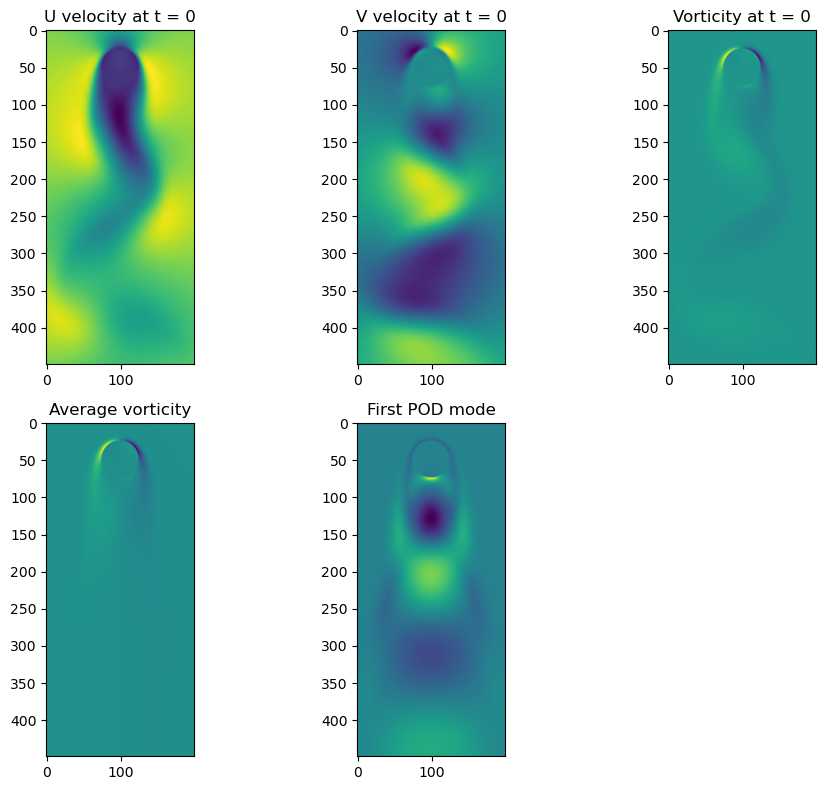

In [17]:
# Choose a time index
t = 0

# Reshape the data to match the grid dimensions
UALL_t = UALL[:, t].reshape((ny, nx))
VALL_t = VALL[:, t].reshape((ny, nx))
VORTALL_t = VORTALL[:, t].reshape((ny, nx))
vortAVG_t = vortAVG.reshape((ny, nx))
vortPHI_t = vortPHI[:, 0].reshape((ny, nx))  # Only plot the first mode

# Plot the data
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1)
plt.imshow(UALL_t, cmap='viridis')
plt.title('U velocity at t = {}'.format(t))

plt.subplot(2, 3, 2)
plt.imshow(VALL_t, cmap='viridis')
plt.title('V velocity at t = {}'.format(t))

plt.subplot(2, 3, 3)
plt.imshow(VORTALL_t, cmap='viridis')
plt.title('Vorticity at t = {}'.format(t))

plt.subplot(2, 3, 4)
plt.imshow(vortAVG_t, cmap='viridis')
plt.title('Average vorticity')

plt.subplot(2, 3, 5)
plt.imshow(vortPHI_t, cmap='viridis')
plt.title('First POD mode')

plt.tight_layout()
plt.show()


## POD Galerkin ROM Evaluation

In our research, we utilize RBniCS, an Python library tailored for reduced basis methods applied to parametrized partial differential equations.RBniCS is really helpful for developing and testing the POD Galerkin Reduced Order Models (ROMs) we use in our flow field studies.
For additional information and access to the source code [RBniCS GitHub repository](https://github.com/RBniCS/RBniCS).


### Defining a mesh

In [2]:
# Defining the mesh

# Parameters for the mesh and cylinder
cylinder_center = (50, 200)  # assumed center of the cylinder
cylinder_radius = 25  # Presumed from the visualization results above

mesh = RectangleMesh(Point(0, 0), Point(nx, ny), m-1, n-1)
plot(mesh, title='Mesh')

NameError: name 'RectangleMesh' is not defined

### Defining subdomains and boundaries

*** Warning: Matplotlib plotting backend does not support mesh function of dim 1. Continuing without plotting...


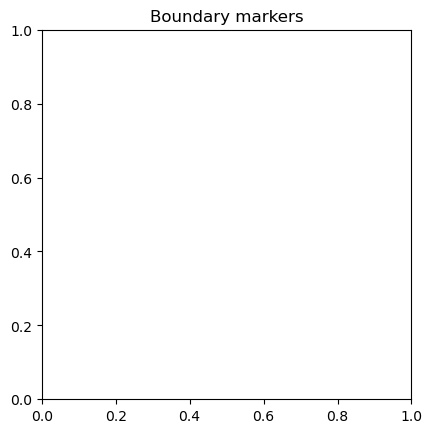

In [ ]:
# Define subdomains for boundaries

# Define a subdomain for the cylinder boundary
class Cylinder(SubDomain):
    def inside(self, x, on_boundary):
        # Check if the point (x[0], x[1]) is inside the cylinder boundary
        
        # Calculate the squared distance between the point (x[0], x[1]) and the center of the cylinder
        distance_squared = (x[0] - cylinder_center[0])**2 + (x[1] - cylinder_center[1])**2
        
        # Check if the squared distance is less than or equal to the square of the cylinder's radius
        # This condition determines whether the point lies within the circular boundary of the cylinder
        return distance_squared <= cylinder_radius**2 and on_boundary

# Define a subdomain for the inlet boundary
class Inlet(SubDomain):
    def inside(self, x, on_boundary):
        # Check if the x-coordinate of the point is near 0.0 (inlet boundary)
        return near(x[0], 0.0) and on_boundary

# Define a subdomain for the outlet boundary
class Outlet(SubDomain):
    def inside(self, x, on_boundary):
        # Check if the x-coordinate of the point is near nx (outlet boundary)
        return near(x[0], nx) and on_boundary

# Define a subdomain for the walls boundary
class Walls(SubDomain):
    def inside(self, x, on_boundary):
        # Check if the y-coordinate of the point is near 0.0 or ny (walls boundary)
        return (near(x[1], 0.0) or near(x[1], ny)) and on_boundary

# Initialize subdomains
cylinder = Cylinder()  
inlet = Inlet() 
outlet = Outlet()  
walls = Walls()  

# Create a mesh function for boundary marking
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
boundaries.set_all(0)  # Set all boundary markers to 0 (default)

# Mark the boundaries with their respective subdomain numbers
cylinder.mark(boundaries, 1)  # Mark the cylinder boundary with subdomain number 1
inlet.mark(boundaries, 2)  # Mark the inlet boundary with subdomain number 2
outlet.mark(boundaries, 3)  # Mark the outlet boundary with subdomain number 3
walls.mark(boundaries, 4)  # Mark the walls boundary with subdomain number 4

# Define a vector function space for the velocity on the mesh, using continuous Galerkin elements of degree 2
V = VectorFunctionSpace(mesh, "CG", 2)

# Defining boundary conditions using velocity profiles or zero velocity at walls
U_inlet = Expression(("1.0", "0.0"), degree=2)  # Prescribed velocity at the inlet (uniform flow at the inlet)
U_walls = Constant((0.0, 0.0))  # Velocity at the walls (no-slip condition)

# Create Dirichlet boundary conditions at each marked subdomain
bc_inlet = DirichletBC(V, U_inlet, boundaries, 2)
bc_walls = DirichletBC(V, U_walls, boundaries, 4)
bc_cylinder = DirichletBC(V, U_walls, boundaries, 1)  # No-slip condition on the cylinder

# List of all boundary conditions for use in solving the Navier-Stokes equations
bcs = [bc_inlet, bc_walls, bc_cylinder]

## POD Galerkin Reduced Order Model

### Class Setup and Initialization
The `CylinderNavierStokes` class is crucial for computational fluid dynamics simulations within the RBniCS framework, consisting of:
- **Vector Space \(V\)**: The function space for solving the Navier-Stokes equations.
- **Mesh**: Defines the computational domain.
- **Boundary Conditions**: Specifies constraints necessary for the physical accuracy of the model.
- **Data Initialization**: External data sources initialize velocity and vorticity fields essential for the simulations.

### Mathematical Formulation and Model Decomposition

#### Affine Decomposition
Affine decomposition optimizes simulation efficiency by separating parameter-dependent components from those that are parameter-independent. Here's how it helps:

- **Precomputation**: By separating parameter-independent components, we can compute these elements just once instead of every time we run a simulation.
  
- **Efficiency**: This separation allows our simulations to run faster because the computationally intensive parts are handled only once.


#### Theta Coefficients
The `compute_theta` function dynamically adjusts scaling coefficients based on current parameters $ \mu$ , which models dynamics within the equations:
$$
\theta_{a} = \mu_0, \quad \theta_{b} = \mu_1, \quad \theta_{c} = \mu_2, \quad \theta_{f} = 1, \quad \theta_{g} = 1, \quad \theta_{\text{dirichlet\_bc\_u}} = 1
$$

### Operator Assembly and Variational Formulation

#### Operator Assembly 
Each term of the affine expansion is handled by the `assemble_operator` function, which constructs necessary matrices and vectors:
$$
\begin{align*}
a & : \text{Diffusion matrix from velocity modes.} \\
b & : \text{Divergence matrix from velocity and pressure modes.} \\
c & : \text{Convective tensor or approximation from velocity field.} \\
f & : \text{Mass matrix from velocity modes.} \\
\end{align*}
$$

#### Variational Formulation of the Navier-Stokes Equations in ROM Construction

The mathematical operators used in the reduced order model address different aspects of the variational formulation of the Navier-Stokes Equations (NSE):

- **Diffusion Matrix**: Represents viscous effects, crucial in the momentum balance of the fluid. It is formulated using velocity gradients to capture the viscous diffusion within the fluid dynamics.
$$
B[i, j] = \int (\nabla \phi_i \cdot \nabla \phi_j) \, dx
$$

- **Transposed Diffusion Matrix**: Ensures symmetry in the viscous terms, which is important for maintaining the physical and mathematical consistency of the model.
$$
(B^T)_{ij} = \int (\nabla \phi_i \cdot (\nabla \phi_j)^T) \, dx
$$

- **Convective Tensor**: Captures the non-linear advection terms of the Navier-Stokes equations, representing the transport phenomena within the fluid due to the velocity field itself.
$$
C[i, j, k] = \int (\phi_i \cdot (\phi_j \otimes \phi_k)) \, dx
$$

- **Mass Matrix**: Reflects the inertial properties of the fluid, essential for modeling the dynamics of the fluid's motion in response to external and internal forces.
$$
M[i, j] = \int (\phi_i \cdot \phi_j) \, dx
$$

- **Divergence Matrix**: Integrates pressure gradients and velocity divergences, crucial for enforcing the incompressibility condition—a fundamental aspect of the Navier-Stokes equations.
$$
P[i, j] = \int (p_i \cdot \text{div}(u_j)) \, dx
$$


In [1]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class CylinderNavierStokes(NavierStokesProblem):

    def __init__(self, V, mesh, boundaries, data):
        super().__init__(V, mesh)
        self.boundaries = boundaries
        dup = TrialFunction(V)
        (self.du, self.dp) = split(dup)
        (self.u, _) = split(self._solution)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)

        self.dx = Measure("dx")(domain=mesh)
        self.ds = Measure("ds")(domain=mesh, subdomain_data=self.boundaries)

        # Initialize velocity and vorticity fields from data
        self.UALL = Function(V).interpolate(data['UALL'])
        self.VALL = Function(V).interpolate(data['VALL'])
        self.VORTALL = Function(V).interpolate(data['VORTALL'])

        # Additional vorticity fields from basis data
        self.vortAVG = Function(V).interpolate(data['vortAVG'])
        self.vortPHI = Function(V).interpolate(data['vortPHI'])
        self.vortUNSTEADY = Function(V).interpolate(data['vortUNSTEADY'])

        self.inlet_velocity = Expression(("1.0", "0.0"), degree=2)
        self.no_slip = Constant((0.0, 0.0))

        self.V = V
        self.mu = mu  # Parameter vector, e.g., [viscosity, density]
        self.dx = dx

    def name(self):
        return "CylinderNavierStokesROM"
    
    # Function to compute the theta multiplicative terms for the affine expansion of the problem.
    # These terms help separate parameter-dependent and parameter-independent parts.
    @compute_theta_for_derivatives  # Used to compute theta terms for derivatives of the problem.
    def compute_theta(self, term):
        mu = self.mu  # Retrieve current parameter values
        if term == "a":
            theta_a0 = mu[0]  # Viscosity affects diffusion in the Navier-Stokes equations.
            return (theta_a0,)  # Return as a single-element tuple
        elif term in ("b", "bt"):
            theta_b0 = mu[1]  # Density might impact pressure-velocity coupling.
            return (theta_b0,)  
        elif term == "c":
            theta_c0 = mu[2]  # Density might affect convective terms.
            return (theta_c0,)  
        elif term == "f":
            theta_f0 = 1.  # External forces are often constant.
            return (theta_f0,)  
        elif term == "g":
            theta_g0 = 1.  # External conditions like boundary conditions are often constant.
            return (theta_g0,)  
        elif term == "dirichlet_bc_u":
            theta_bc00 = 1.  # Boundary conditions might be constant or parameter-dependent.
            return (theta_bc00,)  
        else:
            raise ValueError("Invalid term for compute_theta().")  # Raise an error for unknown terms.


    # This function assembles matrices from discretizing operators for each term in the affine expansion of the problem,
    # building parameter-independent operators that manage the spatial discretization of the PDEs.
    @assemble_operator_for_derivatives  # Decorator used for assembling derivative operators.
    def assemble_operator(self, term, velocity_modes, pressure_modes=None, velocity_field=None):
        # Depending on the term, different matrices or tensors are assembled.
        if term == "a":
            # Assemble the diffusion matrix using the given velocity modes.
            return self.compute_diffusion_matrix(velocity_modes)
        elif term == "b":
            # Assemble the reduced divergence matrix using velocity and pressure modes.
            return self.compute_divergence_reduced_matrix(velocity_modes, pressure_modes)
        elif term == "bt":
            # Assemble the transpose of the reduced divergence matrix.
            return np.transpose(self.compute_divergence_reduced_matrix(velocity_modes, pressure_modes))
        elif term == "c":
            if velocity_field:
                # If a velocity field is provided, approximate the convective term using it.
                return self.compute_convective_term_approximation(velocity_modes, velocity_field)
            else:
                # Otherwise, compute the convective tensor.
                return self.compute_convective_tensor(velocity_modes)
        elif term == "f":
            # Assemble the mass matrix using velocity modes.
            return self.compute_mass_matrix(velocity_modes)
        elif term == "g":
            pass  # Placeholder for specific computations related to term 'g'.
        elif term == "dirichlet_bc_u":
            pass  # No matrix computation needed for boundary conditions handled by FEniCS Dirichlet conditions.
        elif term == "inner_product_u":
            # Assemble the mass matrix for inner product computation on velocity modes.
            return self.compute_mass_matrix(velocity_modes)
        elif term == "inner_product_p":
            pass  # Depending on usage, an appropriate matrix or operation for pressure inner products could be defined.
        else:
            raise ValueError("Invalid term for assemble_operator().")  # Raise an error for unknown terms.
    

    # Computes the diffusion matrix B as part of the discretization process for the Navier-Stokes equations.
    # The matrix B represents the viscous effects in the fluid and is defined element-wise by the equation:
    # B[i, j] = ∫(∇φ_i · ∇φ_j) dx, integrating the gradient of velocity mode φ_i against φ_j over the domain.
    def compute_diffusion_matrix(self, velocity_modes):
        B = np.zeros((len(velocity_modes), len(velocity_modes)))
        for i in range(len(velocity_modes)):
            for j in range(len(velocity_modes)):
                B[i, j] = assemble(inner(grad(velocity_modes[i]), grad(velocity_modes[j]))*self.dx)
        return B

        # Computes the transposed diffusion matrix B^T, aligning with specific requirements for transposed gradients.
    # (B^T)_{ij} = (∫(∇φ_i · (∇φ_j)^T) dx). This function ensures correct handling of transposed gradients.


    # Computes the transposed diffusion matrix B^T. In the context of fluid dynamics,
    # B^T accounts for the symmetric properties of the viscous term in the momentum equation,
    # calculated by: (B^T)_{ij} = ∫(∇φ_i · (∇φ_j)^T) dx.
    def compute_transposed_diffusion_matrix(self, velocity_modes):
        BT = np.zeros((len(velocity_modes), len(velocity_modes)))
        for i in range(len(velocity_modes)):
            for j in range(len(velocity_modes)):
                BT[i, j] = assemble(inner(grad(velocity_modes[i]), grad(velocity_modes[j]))*self.dx)
        return BT

    # Computes the convective tensor C, which models the nonlinear advection term of the fluid.
    # The tensor is built using: C[i, j, k] = ∫(φ_i · (φ_j ⊗ φ_k)) dx, representing the interaction
    # between velocity modes φ_i, φ_j, and φ_k, integral for capturing the dynamics of moving fluids.
    def compute_convective_tensor(self, velocity_modes):
        C = np.zeros((len(velocity_modes), len(velocity_modes), len(velocity_modes)))
        for i in range(len(velocity_modes)):
            for j in range(len(velocity_modes)):
                for k in range(len(velocity_modes)):
                    C[i, j, k] = assemble(velocity_modes[i]*dot(velocity_modes[j], nabla_grad(velocity_modes[k]))*self.dx)
        return C

    # Approximates the convective term vector 'c', important for simplifying the nonlinear interaction
    # in the Navier-Stokes equations. It is computed as: c[i] = ∫(φ_i · (∇ · (u ⊗ u))) dx, where φ_i is a velocity mode
    # and u is the velocity field. This approximation aids in reducing the computational complexity of the model.
    def compute_convective_term_approximation(self, velocity_modes, velocity_field):
        c = np.zeros(len(velocity_modes))
        for i in range(len(velocity_modes)):
            u_grad_u = dot(velocity_field, nabla_grad(velocity_field))
            c[i] = assemble(velocity_modes[i]*u_grad_u*self.dx)
        return c

    # Calculates the mass matrix M, which reflects the inertial properties of the fluid within the ROM.
    # Defined by: M[i, j] = ∫(φ_i · φ_j) dx, it integrates the product of velocity modes φ_i and φ_j,
    # essential for constructing the reduced-order model's dynamical system.
    def compute_mass_matrix(self, velocity_modes):
        M = np.zeros((len(velocity_modes), len(velocity_modes)))
        for i in range(len(velocity_modes)):
            for j in range(len(velocity_modes)):
                M[i, j] = assemble(velocity_modes[i]*velocity_modes[j]*self.dx)
        return M

    # Computes the divergence matrix P, which links the pressure gradient to the velocity divergence
    # in the fluid's motion. It is formulated as: P[i, j] = ∫(p_i · div(u_j)) dx, where p_i is a pressure mode
    # and u_j is a velocity mode. This matrix ensures the incompressibility constraint in the fluid.
    def compute_divergence_reduced_matrix(self, velocity_modes, pressure_modes):
        P = np.zeros((len(pressure_modes), len(velocity_modes)))
        for i in range(len(pressure_modes)):
            for j in range(len(velocity_modes)):
                P[i, j] = assemble(pressure_modes[i]*div(velocity_modes[j])*self.dx)
        return P

        
    

NameError: name 'DEIM' is not defined